1. Binary Segmentation
Phân đoạn nhị phân - phân tách đối tượng (foreground) và nền (background).

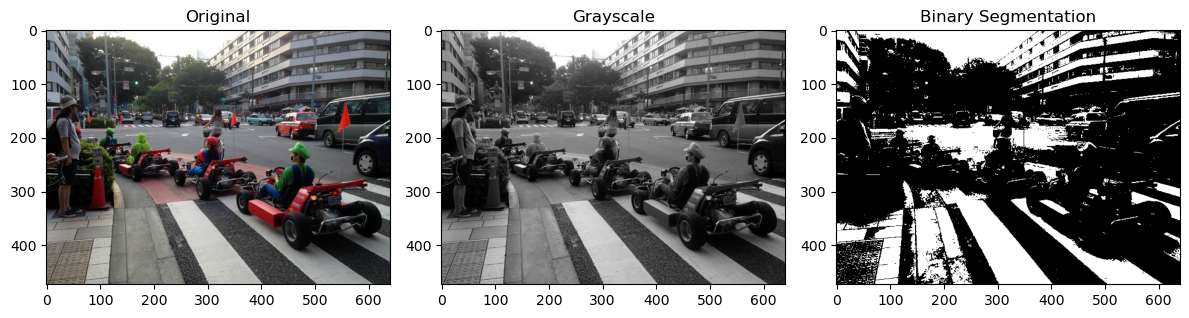

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def binary_segmentation(image_path, threshold=127):
    # Đọc ảnh
    img = cv2.imread(image_path)
    # Chuyển sang ảnh xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Phân đoạn nhị phân sử dụng ngưỡng đơn giản
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Hiển thị kết quả
    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(132), plt.imshow(gray, cmap='gray'), plt.title('Grayscale')
    plt.subplot(133), plt.imshow(binary, cmap='gray'), plt.title('Binary Segmentation')
    plt.tight_layout()
    plt.show()
    
    return binary

binary_segmentation('img.jpg')

2. Semantic Segmentation
Phân đoạn theo ngữ nghĩa - gán nhãn cho từng pixel trong ảnh.

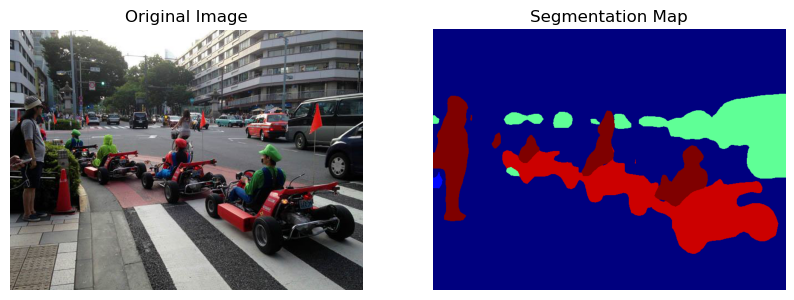

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

# Cập nhật cách tải mô hình với weights
weights = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval()  # Chuyển sang chế độ đánh giá (không huấn luyện)

# Load ảnh đầu vào
image_path = "img.jpg"  # Đổi thành đường dẫn ảnh của bạn
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh với trọng số mới
transform = weights.transforms()
input_tensor = transform(image).unsqueeze(0)  # Thêm batch dimension

# Dự đoán phân đoạn ảnh
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0)  # Lấy nhãn có xác suất cao nhất

# Hiển thị kết quả
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_predictions.cpu(), cmap="jet")
plt.title("Segmentation Map")
plt.axis("off")

plt.show()


3. Instance Segmentation
Phân đoạn theo thực thể - nhận diện và phân đoạn từng thực thể riêng biệt trong ảnh.

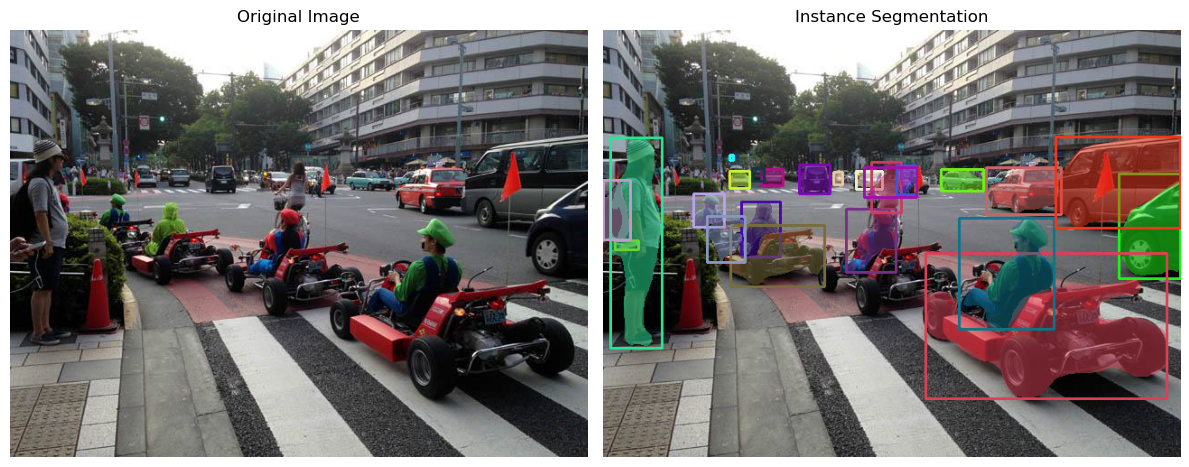

array([[[145, 150, 170],
        [146, 151, 171],
        [146, 153, 171],
        ...,
        [ 62,  54,  35],
        [ 73,  65,  46],
        [ 92,  84,  65]],

       [[145, 150, 170],
        [146, 151, 171],
        [147, 154, 172],
        ...,
        [ 61,  54,  38],
        [ 68,  61,  45],
        [ 83,  76,  60]],

       [[146, 151, 171],
        [147, 152, 172],
        [147, 154, 172],
        ...,
        [ 66,  59,  51],
        [ 72,  65,  57],
        [ 83,  76,  68]],

       ...,

       [[131, 122, 113],
        [120, 111, 102],
        [118, 109, 100],
        ...,
        [ 40,  40,  42],
        [ 27,  27,  29],
        [ 17,  17,  19]],

       [[110, 101,  92],
        [115, 106,  97],
        [117, 108,  99],
        ...,
        [ 48,  48,  50],
        [ 43,  43,  45],
        [ 30,  30,  32]],

       [[117, 108, 101],
        [116, 107, 100],
        [130, 121, 112],
        ...,
        [ 46,  46,  48],
        [ 40,  40,  42],
        [ 41,  41,  43]]

In [6]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

def instance_segmentation(image_path):
    """
    Thực hiện instance segmentation bằng Mask R-CNN với mô hình pre-trained
    """
    # Tải mô hình đã huấn luyện sẵn với weights chính xác
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)
    model.eval()

    # Đọc và xử lý ảnh
    image = Image.open(image_path).convert("RGB")
    transform = weights.transforms()
    img_tensor = transform(image)

    # Dự đoán
    with torch.no_grad():
        prediction = model([img_tensor])

    # Trích xuất kết quả
    img_np = np.array(image)
    masks = prediction[0]['masks'].detach().cpu().numpy()
    boxes = prediction[0]['boxes'].detach().cpu().numpy()
    scores = prediction[0]['scores'].detach().cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Chỉ giữ các dự đoán có điểm số cao
    threshold = 0.7
    high_score_idxs = np.where(scores > threshold)[0]

    # Tạo ảnh kết quả
    result_img = img_np.copy()

    # Hiển thị kết quả
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(img_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)

    # Vẽ các mask và bounding box
    for i in high_score_idxs:
        mask = masks[i, 0]
        box = boxes[i].astype(np.int32)
        label = labels[i]

        # Tạo màu ngẫu nhiên cho mỗi thực thể
        color = np.random.randint(0, 255, (3,), dtype=np.uint8)

        # Áp dụng mask
        colored_mask = np.zeros_like(img_np, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = np.where(mask > 0.5, color[c], 0)

        # Kết hợp mask với ảnh gốc
        alpha = 0.5
        mask_condition = mask[:, :, np.newaxis] > 0.5
        result_img = np.where(mask_condition, (1 - alpha) * result_img + alpha * colored_mask, result_img)

        # Vẽ bounding box
        cv2.rectangle(result_img, (box[0], box[1]), (box[2], box[3]), color.tolist(), 2)

    # Chuyển đổi kết quả về kiểu uint8 để tránh lỗi khi hiển thị
    result_img = np.clip(result_img, 0, 255).astype(np.uint8)

    plt.imshow(result_img)
    plt.title('Instance Segmentation')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return result_img

# Chạy hàm với ảnh đầu vào
instance_segmentation('img.jpg')
